In [47]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [48]:
def crop_brain_contour(image, plot=False):

    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)


    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')

        plt.show()

    return new_image

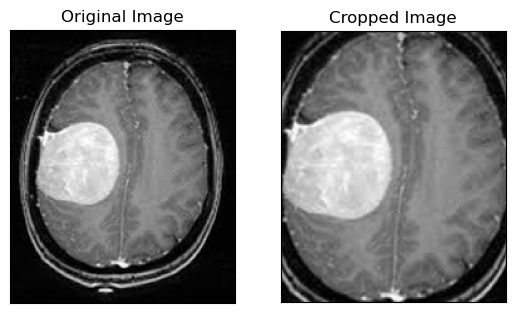

In [49]:
ex_img = cv2.imread('C:\\ML projects\\brain tumor\\bt_dataset\\brain_tumor_dataset\\yes\\Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [50]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle

def load_data(dir_list, image_size):
    """
    Read images, resize, and normalize them.
    Arguments:
        dir_list: list of strings representing file directories.
        image_size: tuple, size to which the images should be resized.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            # load the image
            full_path = os.path.join(directory, filename)
            image = cv2.imread(full_path)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y


In [51]:
augmented_path = 'C:\\ML projects\\brain tumor\\bt_dataset\\augmented_data'
augmented_yes = 'C:\\ML projects\\brain tumor\\bt_dataset\\augmented_data\\yes'
augmented_no = 'C:\\ML projects\\brain tumor\\bt_dataset\\augmented_data\\no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

# Check if directories exist
if not os.path.exists(augmented_path):
    print(f"Directory not found: {augmented_path}")
elif not os.path.exists(augmented_yes):
    print(f"Directory not found: {augmented_yes}")
elif not os.path.exists(augmented_no):
    print(f"Directory not found: {augmented_no}")
else:
    # Call load_data function
    X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

    # Rest of your code here


Number of examples is: 2062
X shape is: (2062, 240, 240, 3)
y shape is: (2062, 1)


In [52]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

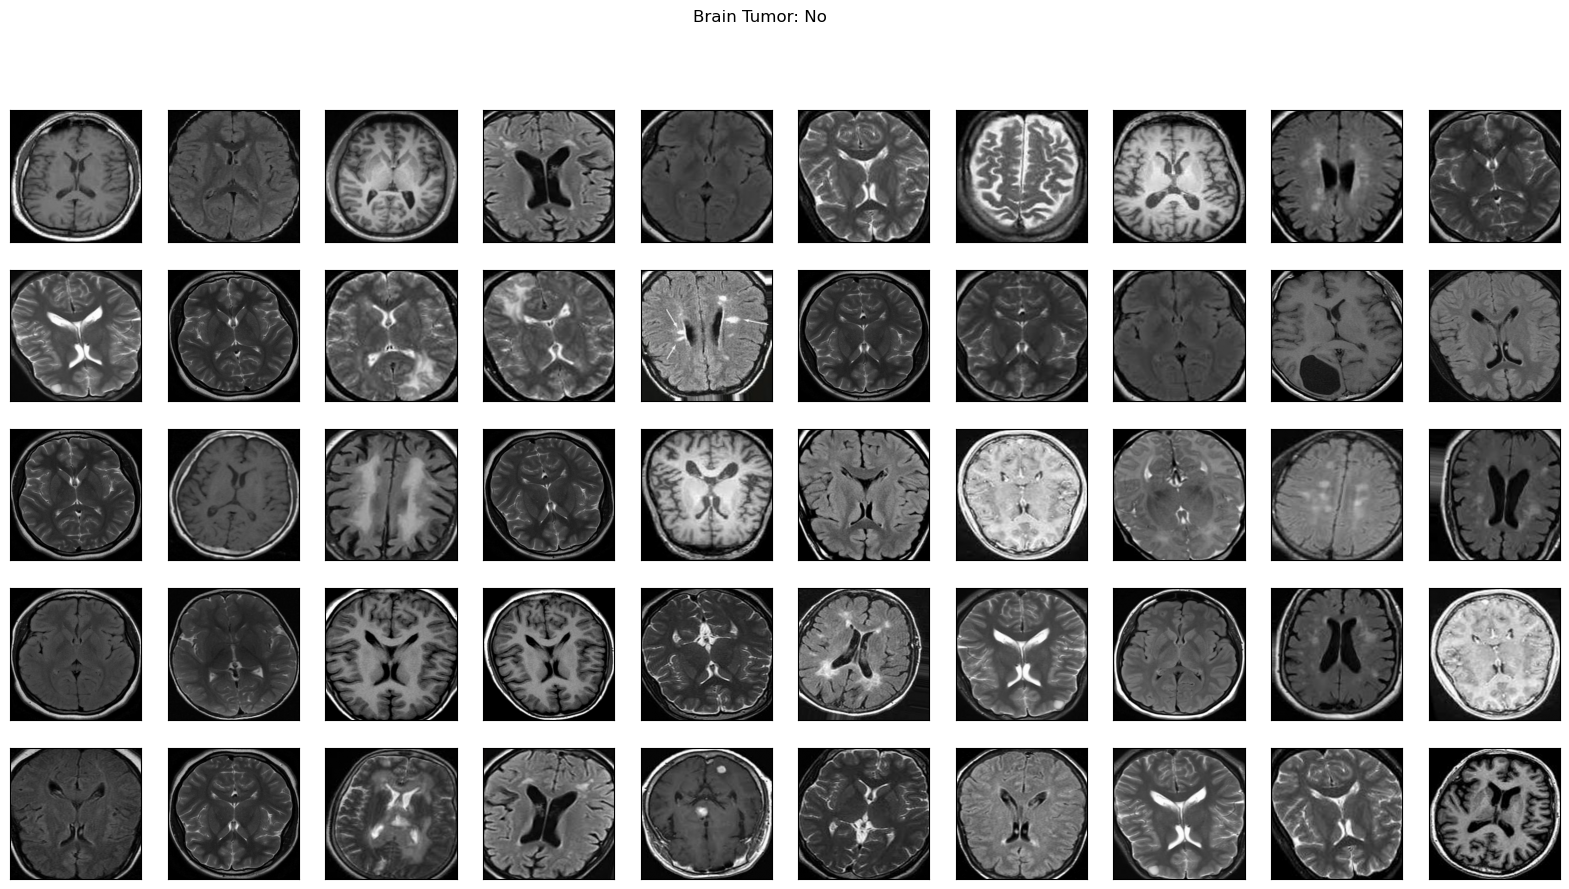

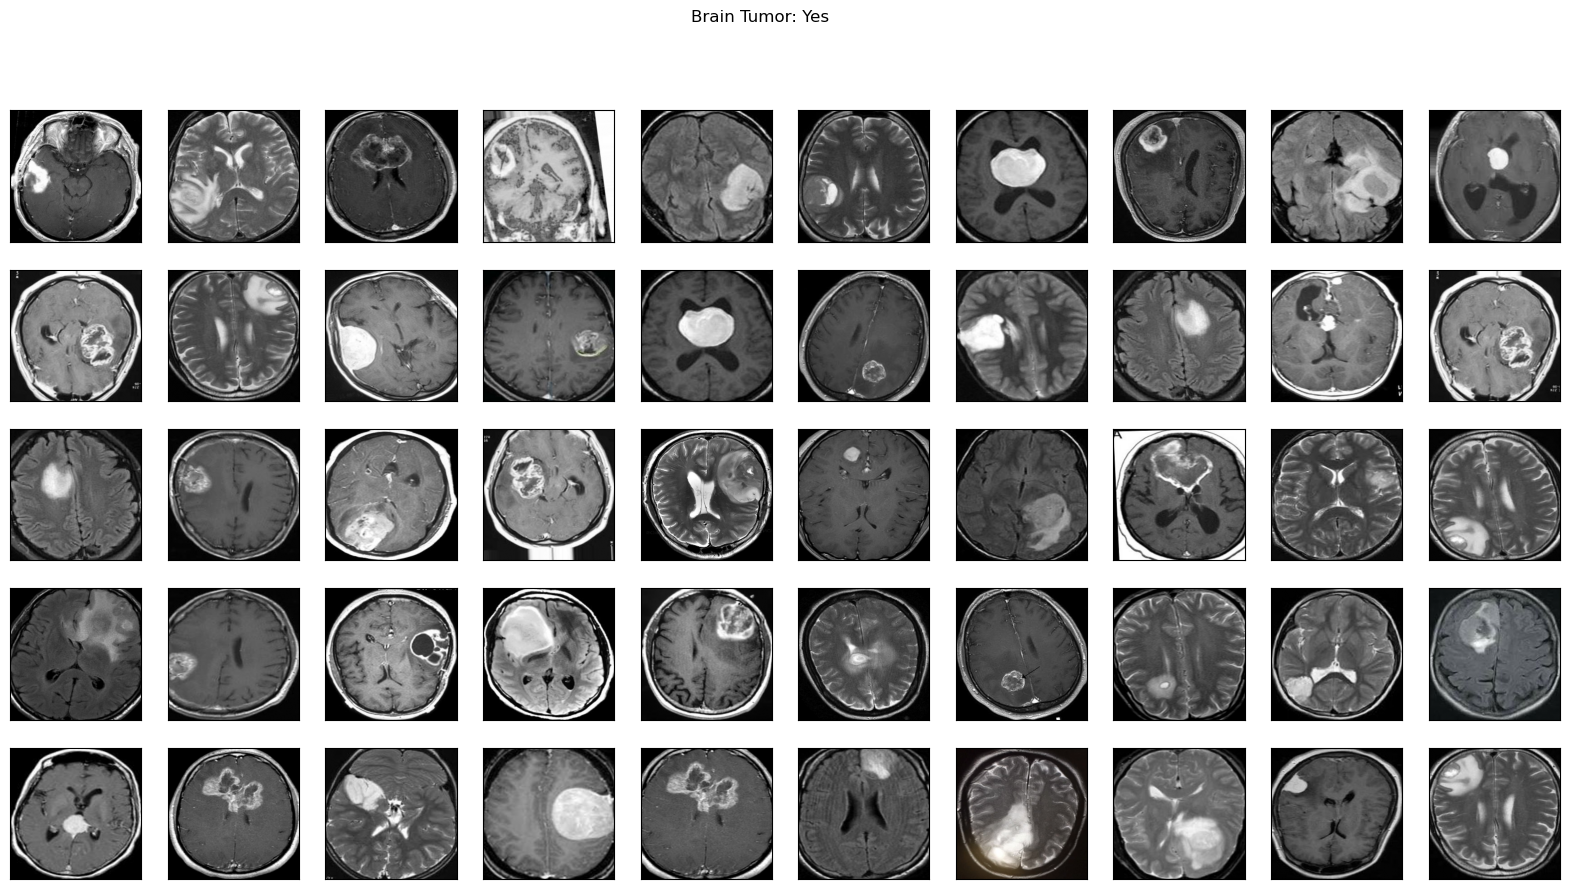

In [53]:
plot_sample_images(X, y)

In [54]:
def split_data(X, y, test_size=0.2):

    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [55]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [56]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1443
number of development examples = 310
number of test examples = 309
X_train shape: (1443, 240, 240, 3)
Y_train shape: (1443, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (309, 240, 240, 3)
Y_test shape: (309, 1)


In [57]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [58]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)

    score = f1_score(y_true, y_pred)

    return score

In [25]:
%pip install qiskit


Note: you may need to restart the kernel to use updated packages.


In [39]:
%pip install qiskit-aer

   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.5 MB 363.1 kB/s eta 0:00:26
   ---------------------------------------- 0.1/9.5 MB 363.1 kB/s eta 0:00:26
   ---------------------------------------- 0.1/9.5 MB 363.1 kB/s eta 0:00:26
   ---------------------------------------- 0.1/9.5 MB 290.5 kB/s eta 0:00:33
   ---------------------------------------- 0.1/9.5 MB 290.5 kB/s e

In [59]:
import numpy as np
import qiskit
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.visualization import circuit_drawer
from tensorflow.keras.layers import Input, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_qiskit_quantum_cnn_model(input_shape):
    X_input = Input(input_shape)
    
    # Apply Quantum Convolutional Layer
    X = qiskit_quantum_layer(X_input)
    
    # Batch Normalization and ReLU
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    # Max Pooling
    X = MaxPooling2D((4, 4))(X)
    
    # Flatten
    X = Flatten()(X)
    
    # Fully-connected layer
    X = Dense(1, activation='sigmoid', name='fc')(X)
    
    # Create model
    model = Model(inputs=X_input, outputs=X, name='QuantumCNNModel')
    
    return model

def qiskit_quantum_layer(inputs):
    # Assuming inputs is a tensor
    batch_size, height, width, channels = inputs.shape.as_list()
    
    # Create a quantum circuit
    quantum_circuit = QuantumCircuit(2)
    quantum_circuit.h([0, 1])
    
    # ... Add more quantum operations based on your requirements ...
    
    # Transpile the quantum circuit
    compiled_circuit = transpile(quantum_circuit, Aer.get_backend('qasm_simulator'))
    
    # Convert the quantum circuit to OpenQASM string
    qasm_string = compiled_circuit.qasm()
    
    # Apply the quantum operation to the input tensor
    # Use qasm_string as needed in your quantum processing
    output = inputs
    return output


In [60]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [61]:
model = build_qiskit_quantum_cnn_model(IMG_SHAPE)

In [62]:
model.summary()

Model: "QuantumCNNModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 batch_normalization (Batch  (None, 240, 240, 3)       12        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 240, 240, 3)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 3)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 10800)             0         
                                                                 
 fc (Dense)                  (None, 1)             

In [63]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [64]:
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [65]:
from keras.callbacks import ModelCheckpoint

# Unique file name that will include the epoch and the validation (development) accuracy
filepath = "cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"

# Save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint(
    "models/{}.model".format(filepath),
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)


In [66]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10


45/46 [============================>.] - ETA: 0s - loss: 0.8812 - accuracy: 0.5979
Epoch 1: val_accuracy improved from -inf to 0.62581, saving model to models\cnn-parameters-improvement-01-0.63.model
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.63.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.63.model\assets


46/46 [==============================] - 13s 241ms/step - loss: 0.8803 - accuracy: 0.5981 - val_loss: 0.6436 - val_accuracy: 0.6258
Epoch 2/10
45/46 [============================>.] - ETA: 0s - loss: 0.6458 - accuracy: 0.6861
Epoch 2: val_accuracy improved from 0.62581 to 0.65161, saving model to models\cnn-parameters-improvement-02-0.65.model
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.65.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.65.model\assets


46/46 [==============================] - 10s 218ms/step - loss: 0.6463 - accuracy: 0.6854 - val_loss: 0.6293 - val_accuracy: 0.6516
Epoch 3/10
45/46 [============================>.] - ETA: 0s - loss: 0.5508 - accuracy: 0.7306
Epoch 3: val_accuracy improved from 0.65161 to 0.67742, saving model to models\cnn-parameters-improvement-03-0.68.model
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.68.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.68.model\assets


46/46 [==============================] - 10s 217ms/step - loss: 0.5515 - accuracy: 0.7297 - val_loss: 0.6005 - val_accuracy: 0.6774
Epoch 4/10
46/46 [==============================] - ETA: 0s - loss: 0.4970 - accuracy: 0.7568
Epoch 4: val_accuracy improved from 0.67742 to 0.70645, saving model to models\cnn-parameters-improvement-04-0.71.model
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.71.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.71.model\assets


46/46 [==============================] - 10s 214ms/step - loss: 0.4970 - accuracy: 0.7568 - val_loss: 0.5910 - val_accuracy: 0.7065
Epoch 5/10
45/46 [============================>.] - ETA: 0s - loss: 0.4384 - accuracy: 0.8076
Epoch 5: val_accuracy did not improve from 0.70645
46/46 [==============================] - 9s 191ms/step - loss: 0.4378 - accuracy: 0.8080 - val_loss: 0.5826 - val_accuracy: 0.7000
Epoch 6/10
45/46 [============================>.] - ETA: 0s - loss: 0.4173 - accuracy: 0.8174
Epoch 6: val_accuracy did not improve from 0.70645
46/46 [==============================] - 9s 191ms/step - loss: 0.4167 - accuracy: 0.8177 - val_loss: 0.6067 - val_accuracy: 0.6774
Epoch 7/10
45/46 [============================>.] - ETA: 0s - loss: 0.4137 - accuracy: 0.8146
Epoch 7: val_accuracy did not improve from 0.70645
46/46 [==============================] - 9s 192ms/step - loss: 0.4154 - accuracy: 0.8143 - val_loss: 0.8003 - val_accuracy: 0.6645
Epoch 8/10
45/46 [======================

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.72.model\assets


46/46 [==============================] - 10s 217ms/step - loss: 0.3344 - accuracy: 0.8649 - val_loss: 0.6486 - val_accuracy: 0.7161
Elapsed time: 0:1:39.4


In [67]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
45/46 [============================>.] - ETA: 0s - loss: 0.2921 - accuracy: 0.8861
Epoch 1: val_accuracy did not improve from 0.71613
46/46 [==============================] - 10s 205ms/step - loss: 0.2924 - accuracy: 0.8857 - val_loss: 0.6981 - val_accuracy: 0.7000
Epoch 2/3
45/46 [============================>.] - ETA: 0s - loss: 0.2867 - accuracy: 0.8951
Epoch 2: val_accuracy improved from 0.71613 to 0.71935, saving model to models\cnn-parameters-improvement-02-0.72.model
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.72.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.72.model\assets


46/46 [==============================] - 10s 216ms/step - loss: 0.2863 - accuracy: 0.8954 - val_loss: 0.6900 - val_accuracy: 0.7194
Epoch 3/3
45/46 [============================>.] - ETA: 0s - loss: 0.2794 - accuracy: 0.8972
Epoch 3: val_accuracy did not improve from 0.71935
46/46 [==============================] - 9s 190ms/step - loss: 0.2796 - accuracy: 0.8967 - val_loss: 0.7612 - val_accuracy: 0.6677
Elapsed time: 0:0:32.8


In [68]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
45/46 [============================>.] - ETA: 0s - loss: 0.2705 - accuracy: 0.9007
Epoch 1: val_accuracy did not improve from 0.71935
46/46 [==============================] - 9s 202ms/step - loss: 0.2702 - accuracy: 0.9009 - val_loss: 0.7296 - val_accuracy: 0.7000
Epoch 2/3
45/46 [============================>.] - ETA: 0s - loss: 0.2865 - accuracy: 0.8819
Epoch 2: val_accuracy did not improve from 0.71935
46/46 [==============================] - 9s 192ms/step - loss: 0.2861 - accuracy: 0.8822 - val_loss: 0.8166 - val_accuracy: 0.6839
Epoch 3/3
45/46 [============================>.] - ETA: 0s - loss: 0.2935 - accuracy: 0.8778
Epoch 3: val_accuracy did not improve from 0.71935
46/46 [==============================] - 9s 190ms/step - loss: 0.2935 - accuracy: 0.8780 - val_loss: 0.7924 - val_accuracy: 0.6871
Elapsed time: 0:0:30.9


In [69]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
45/46 [============================>.] - ETA: 0s - loss: 0.2343 - accuracy: 0.9049
Epoch 1: val_accuracy did not improve from 0.71935
46/46 [==============================] - 9s 198ms/step - loss: 0.2340 - accuracy: 0.9051 - val_loss: 0.7581 - val_accuracy: 0.7065
Epoch 2/3
45/46 [============================>.] - ETA: 0s - loss: 0.2144 - accuracy: 0.9243
Epoch 2: val_accuracy did not improve from 0.71935
46/46 [==============================] - 9s 191ms/step - loss: 0.2141 - accuracy: 0.9245 - val_loss: 0.9998 - val_accuracy: 0.6581
Epoch 3/3
45/46 [============================>.] - ETA: 0s - loss: 0.2086 - accuracy: 0.9333
Epoch 3: val_accuracy did not improve from 0.71935
46/46 [==============================] - 9s 190ms/step - loss: 0.2089 - accuracy: 0.9328 - val_loss: 0.8684 - val_accuracy: 0.6935
Elapsed time: 0:0:28.4


In [70]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
45/46 [============================>.] - ETA: 0s - loss: 0.2396 - accuracy: 0.9069
Epoch 1: val_accuracy did not improve from 0.71935
46/46 [==============================] - 9s 203ms/step - loss: 0.2393 - accuracy: 0.9071 - val_loss: 0.8447 - val_accuracy: 0.7161
Epoch 2/5
45/46 [============================>.] - ETA: 0s - loss: 0.1888 - accuracy: 0.9368
Epoch 2: val_accuracy did not improve from 0.71935
46/46 [==============================] - 9s 192ms/step - loss: 0.1890 - accuracy: 0.9369 - val_loss: 0.8717 - val_accuracy: 0.6871
Epoch 3/5
45/46 [============================>.] - ETA: 0s - loss: 0.2828 - accuracy: 0.8889
Epoch 3: val_accuracy did not improve from 0.71935
46/46 [==============================] - 9s 192ms/step - loss: 0.2833 - accuracy: 0.8884 - val_loss: 0.9735 - val_accuracy: 0.6742
Epoch 4/5
45/46 [============================>.] - ETA: 0s - loss: 0.1905 - accuracy: 0.9472
Epoch 4: val_accuracy did not improve from 0.71935
46/46 [========================

In [ ]:
history = model.history.history

In [ ]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [ ]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_accuracy = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

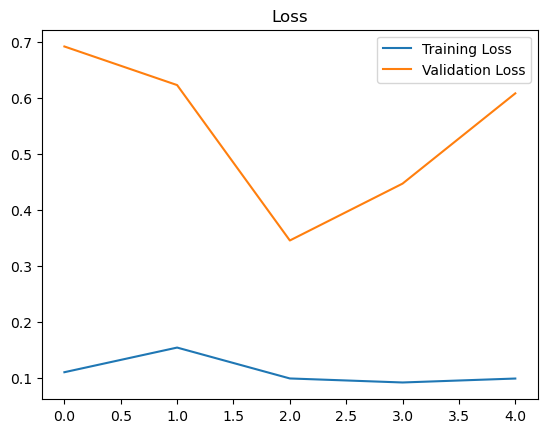

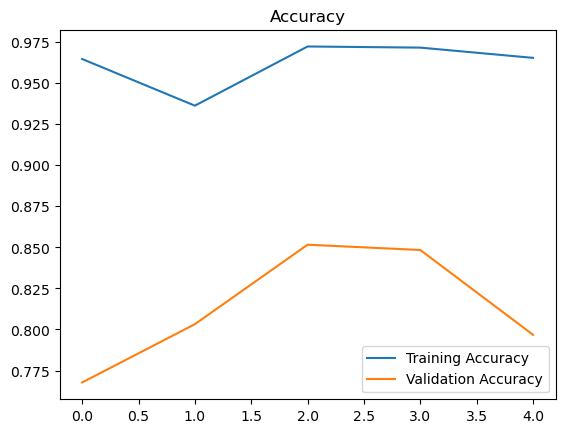

In [ ]:
plot_metrics(history)

In [54]:
best_model = load_model(filepath='models\cnn-parameters-improvement-01-0.87.model')

In [55]:
best_model.metrics_names

['loss', 'accuracy']

In [56]:
loss, accuracy = best_model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 1s 104ms/step - loss: 0.2665 - accuracy: 0.8964


In [57]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {accuracy}")

Test Loss = 0.26647064089775085
Test Accuracy = 0.8964401483535767


In [58]:
y_test_prob = best_model.predict(X_test)

10/10 [==============================] - 1s 99ms/step


In [66]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score (test): {f1score}")

F1 score (test): 0.9


In [60]:
y_val_prob = best_model.predict(X_val)

10/10 [==============================] - 1s 99ms/step


In [65]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score(val): {f1score_val}")

F1 score(val): 0.8666666666666667


In [62]:
def data_percentage(y):

    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive

    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m

    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}")
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}")



In [63]:
# the whole data
data_percentage(y)

Number of examples: 2062
Percentage of positive examples: 52.570320077594566%, number of pos examples: 1084
Percentage of negative examples: 47.429679922405434%, number of neg examples: 978


In [64]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1443
Percentage of positive examples: 54.054054054054056%, number of pos examples: 780
Percentage of negative examples: 45.945945945945944%, number of neg examples: 663
Validation Data:
Number of examples: 310
Percentage of positive examples: 47.41935483870968%, number of pos examples: 147
Percentage of negative examples: 52.58064516129032%, number of neg examples: 163
Testing Data:
Number of examples: 309
Percentage of positive examples: 50.80906148867314%, number of pos examples: 157
Percentage of negative examples: 49.19093851132686%, number of neg examples: 152
